## Building a model to predict putative APOBEC1 sequence human
### Producing H0 and H1 models
In this notebook, using well known edited sites sequences and not-edited positions will be build a model to predict if a given sequence comes from the editing signature or not to further filter putative editing sites give by CtoUclassifier algorithms.
Here features for H0 (no editing) and H1 models will be extraced and saved to disk.

In [1]:
# import basic modules
import os, sys, random
import numpy as np
import pandas as pd
import pysam
from scipy.stats import chi2
from tqdm import tqdm
import matplotlib.pyplot as plt

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl

In [27]:
# define input paths
ref_filepath = "/lustre/bio_running/refs/GRCh38.primary_assembly.genome.filtered.fa"
ed_pos_filepath = "/lustre/bio_running/conticello/src/src_ILLUMINA/src_jupyter_notebooks/reliable_ed_pos_oxp_wt_annotated.tsv"
oxp_reditables_filtered_filepaths = {"oxp1":"/lustre/bio_running/conticello/illumina/oxp1/DnaRna_470872555/outTable_470872555_filtered.filtered",
                                     "oxp2":"/lustre/bio_running/conticello/illumina/oxp2/DnaRna_73346045/outTable_73346045_filtered.filtered",
                                     "oxp3":"/lustre/bio_running/conticello/illumina/oxp3/DnaRna_808842865/outTable_808842865_filtered.filtered"}
wt_reditables_filtered_filepaths =  {"wt1":"/lustre/bio_running/conticello/illumina/wt1/DnaRna_505821894/outTable_505821894_filtered.filtered",
                                     "wt2":"/lustre/bio_running/conticello/illumina/wt2/DnaRna_83292749/outTable_83292749_filtered.filtered",
                                     "wt3":"/lustre/bio_running/conticello/illumina/wt3/DnaRna_296402424/outTable_296402424_filtered.filtered"}

## Extract features

In [106]:
# loading well kwnown edited position table focusing on sites with at least 5% of CT editing levels on OXP samples
ed_pos = pd.read_table(ed_pos_filepath)
ed_pos = ed_pos[(ed_pos["Frequency_oxp1"]>=0.05)&(ed_pos["Frequency_oxp2"]>=0.05)&(ed_pos["Frequency_oxp3"]>=0.05)].copy()
ed_pos

,Region,Position,Reference,Strand,Coverage-q30_oxp1,"BaseCount[A,C,G,T]_oxp1",AllSubs_oxp1,Frequency_oxp1,Coverage-q30_oxp2,"BaseCount[A,C,G,T]_oxp2",...,Frequency_wt2,Coverage-q30_wt3,"BaseCount[A,C,G,T]_wt3",AllSubs_wt3,Frequency_wt3,Frequency_mean_wt,Frequency_std_wt,Func.refGene,Gene.refGene,ExonicFunc.refGene
2,chrX,10448188,C,0,194,"[0, 184, 0, 10]",CT,0.05,102,"[0, 84, 0, 18]",...,0.0,226,"[0, 226, 0, 0]",-,0.0,0.0,0.0,UTR3,MID1,.
9,chrX,12822954,C,1,546,"[0, 507, 0, 39]",CT,0.07,382,"[0, 314, 0, 68]",...,0.0,520,"[0, 520, 0, 0]",-,0.0,0.0,0.0,UTR3,PRPS2,.
11,chrX,12823260,C,1,520,"[0, 495, 0, 25]",CT,0.05,349,"[0, 319, 0, 30]",...,0.0,451,"[0, 451, 0, 0]",-,0.0,0.0,0.0,UTR3,PRPS2,.
13,chrX,12823297,C,1,467,"[0, 423, 0, 44]",CT,0.09,297,"[0, 231, 0, 66]",...,0.0,399,"[0, 399, 0, 0]",-,0.0,0.0,0.0,UTR3,PRPS2,.
15,chrX,12823417,C,1,547,"[0, 464, 0, 83]",CT,0.15,337,"[0, 219, 0, 118]",...,0.0,480,"[0, 480, 0, 0]",-,0.0,0.0,0.0,UTR3,PRPS2,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17052,chr8,132847488,C,1,158,"[0, 148, 0, 10]",CT,0.06,227,"[0, 188, 0, 39]",...,0.0,139,"[0, 139, 0, 0]",-,0.0,0.0,0.0,UTR3,PHF20L1,.
17059,chr8,140531731,C,0,196,"[0, 179, 0, 17]",CT,0.09,201,"[0, 163, 0, 38]",...,0.0,138,"[0, 138, 0, 0]",-,0.0,0.0,0.0,UTR3,AGO2,.
17060,chr8,140531935,C,0,253,"[0, 229, 0, 24]",CT,0.09,242,"[0, 201, 0, 41]",...,0.0,194,"[0, 194, 0, 0]",-,0.0,0.0,0.0,UTR3,AGO2,.
17061,chr8,140658532,C,0,121,"[0, 115, 0, 6]",CT,0.05,187,"[0, 155, 0, 32]",...,0.0,146,"[0, 146, 0, 0]",-,0.0,0.0,0.0,UTR3,PTK2,.


In [107]:
# open filtered reditools tables
# define column names
col_names = ["Region", "Position", "Reference", "Strand", "Coverage", "MeanQual", "BaseCount[A,C,G,T]", "AllSubs", "Frequency"]
# OXPs
print("### Opening OXPs REDItools filtered tables containign C reference sites.\n")
oxp_reditables_filtered = {}
for oxp in oxp_reditables_filtered_filepaths.keys():
    filepath = oxp_reditables_filtered_filepaths[oxp]
    print(oxp, filepath)
    oxp_reditables_filtered[oxp] = pd.read_table(filepath, header=None, names=col_names, index_col=False)
    print(oxp_reditables_filtered[oxp])
    print()
# WTs
print()
print()
print("### Opening WTs REDItools filtered tables containign C reference sites.\n")
wt_reditables_filtered = {}
for wt in wt_reditables_filtered_filepaths.keys():
    filepath = wt_reditables_filtered_filepaths[wt]
    print(wt, filepath)
    wt_reditables_filtered[wt] = pd.read_table(filepath, header=None, names=col_names, index_col=False)
    print(wt_reditables_filtered[wt])

### Opening OXPs REDItools filtered tables containign C reference sites.

oxp1 /lustre/bio_running/conticello/illumina/oxp1/DnaRna_470872555/outTable_470872555_filtered.filtered
        Region   Position Reference  Strand  Coverage  MeanQual  \
0         chrY   11164705         C       0        52     45.54   
1         chrY   11164706         C       0        53     45.15   
2         chrY   11164713         C       0        55     44.85   
3         chrY   11164718         C       0        59     44.53   
4         chrY   11164719         C       0        57     44.79   
...        ...        ...       ...     ...       ...       ...   
5469312   chr8  145055960         C       1       106     42.70   
5469313   chr8  145055969         C       1        96     43.28   
5469314   chr8  145055970         C       1        95     43.88   
5469315   chr8  145056011         C       1        75     38.32   
5469316   chr8  145056012         C       1        75     38.13   

        BaseCount

In [108]:
# drop sites with unkwnown strand (i.e. strand == 2, if presents)
# OXPs
print("### Dropping OXPs sites with unknown strand...")
for oxp in oxp_reditables_filtered.keys():
    oxp_reditables_filtered[oxp] = oxp_reditables_filtered[oxp].query("Strand != 2").copy()
    oxp_reditables_filtered[oxp].reset_index(drop=True, inplace=True)
    print(oxp_reditables_filtered[oxp])
# WTs
print()
print()
print("### Dropping WTs sites with unknown strand...")
for wt in wt_reditables_filtered.keys():
    wt_reditables_filtered[wt] = wt_reditables_filtered[wt].query("Strand != 2").copy()
    wt_reditables_filtered[wt].reset_index(drop=True, inplace=True)
    print(wt_reditables_filtered[wt])

### Dropping OXPs sites with unknown strand...
        Region   Position Reference  Strand  Coverage  MeanQual  \
0         chrY   11164705         C       0        52     45.54   
1         chrY   11164706         C       0        53     45.15   
2         chrY   11164713         C       0        55     44.85   
3         chrY   11164718         C       0        59     44.53   
4         chrY   11164719         C       0        57     44.79   
...        ...        ...       ...     ...       ...       ...   
5431887   chr8  145055960         C       1       106     42.70   
5431888   chr8  145055969         C       1        96     43.28   
5431889   chr8  145055970         C       1        95     43.88   
5431890   chr8  145056011         C       1        75     38.32   
5431891   chr8  145056012         C       1        75     38.13   

        BaseCount[A,C,G,T] AllSubs  Frequency  
0            [0, 52, 0, 0]       -        0.0  
1            [0, 53, 0, 0]       -        0.0  
2   

In [109]:
# eliminate from original filtered reditools table sites that are edited from well kwnown edited sites
# produce edited sites set
ed_sites_set = set()
for s in ed_pos.itertuples():
    ed_sites_set.add(f"{s[1]}:{s[2]}:{s[4]}")
print(len(ed_sites_set))
print(ed_sites_set)

7282
{'chr10:113908856:1', 'chr18:35703529:1', 'chr13:72709885:0', 'chr1:211749673:0', 'chr2:38744531:0', 'chr1:225496424:0', 'chr2:10571981:0', 'chr3:140977098:1', 'chr17:29545416:1', 'chr16:30444029:0', 'chr3:196050363:0', 'chr8:103068969:1', 'chr6:24705588:0', 'chr14:52643419:0', 'chr5:115615487:0', 'chr15:32636830:1', 'chr2:108684230:1', 'chr12:69273487:1', 'chr14:70326332:0', 'chr20:49113884:0', 'chr4:56394156:0', 'chr15:42437302:0', 'chr4:154539201:0', 'chr12:43794400:0', 'chr3:136338170:0', 'chr10:121836774:0', 'chr5:113019932:1', 'chr10:117341035:0', 'chr1:184691734:0', 'chr8:39104580:1', 'chr6:113861462:1', 'chr1:162528090:1', 'chr16:66616307:0', 'chr4:78919316:0', 'chr11:34099978:1', 'chr1:219968625:0', 'chr8:116846580:0', 'chr16:31915215:1', 'chr8:53967443:0', 'chr1:40293213:1', 'chr16:21617897:1', 'chr3:25618672:0', 'chr14:50419945:0', 'chr12:132725831:0', 'chr14:50456572:0', 'chr3:150584210:1', 'chr9:132689654:1', 'chr1:211746615:0', 'chr14:54424288:0', 'chr5:43289650:0', 

In [110]:
print("### OXPs...")
for oxp in oxp_reditables_filtered.keys():
    print(f"\nWorking on {oxp} reditool table...")
    reditable = oxp_reditables_filtered[oxp]
    print(reditable.shape)
    indexes_to_drop = []
    with tqdm(total=reditable.shape[0]) as pbar:
        for s in reditable.itertuples():
            site = f"{s[1]}:{s[2]}:{s[4]}"
            if site in ed_sites_set:
                indexes_to_drop.append(s[0])
            pbar.update(1)
    print(len(indexes_to_drop))
    # filter out edited positions
    reditable.drop(indexes_to_drop, axis=0, inplace=True)
    reditable.reset_index(drop=True, inplace=True)
    print(reditable.shape, oxp_reditables_filtered[oxp].shape)

print()
print("### WTs...")
for wt in wt_reditables_filtered.keys():
    print(f"\nWorking on {wt} reditool table...")
    reditable = wt_reditables_filtered[wt]
    print(reditable.shape)
    indexes_to_drop = []
    with tqdm(total=reditable.shape[0]) as pbar:
        for s in reditable.itertuples():
            site = f"{s[1]}:{s[2]}:{s[4]}"
            if site in ed_sites_set:
                indexes_to_drop.append(s[0])
            pbar.update(1)
    print(len(indexes_to_drop))
    # filter out edited positions
    reditable.drop(indexes_to_drop, axis=0, inplace=True)
    reditable.reset_index(drop=True, inplace=True)
    print(reditable.shape, wt_reditables_filtered[wt].shape)

### OXPs...

Working on oxp1 reditool table...
(5431892, 9)


100%|██████████| 5431892/5431892 [00:08<00:00, 624402.95it/s]


7280
(5424612, 9) (5424612, 9)

Working on oxp2 reditool table...
(5255161, 9)


100%|██████████| 5255161/5255161 [00:08<00:00, 624782.39it/s]


7280
(5247881, 9) (5247881, 9)

Working on oxp3 reditool table...
(4435173, 9)


100%|██████████| 4435173/4435173 [00:06<00:00, 634473.25it/s]


7280
(4427893, 9) (4427893, 9)

### WTs...

Working on wt1 reditool table...
(4672634, 9)


100%|██████████| 4672634/4672634 [00:07<00:00, 632912.21it/s]


7280
(4665354, 9) (4665354, 9)

Working on wt2 reditool table...
(6178597, 9)


100%|██████████| 6178597/6178597 [00:09<00:00, 630314.10it/s]


7280
(6171317, 9) (6171317, 9)

Working on wt3 reditool table...
(4853320, 9)


100%|██████████| 4853320/4853320 [00:08<00:00, 604948.88it/s]


7280
(4846040, 9) (4846040, 9)


In [124]:
# merge OXPs filtered tables
oxp_merged = pd.merge(oxp_reditables_filtered["oxp1"], oxp_reditables_filtered["oxp2"], 
                      how="inner", on=["Region", "Position", "Reference", "Strand"], suffixes=["_oxp1", "_oxp2"])
oxp_merged = pd.merge(oxp_merged, oxp_reditables_filtered["oxp3"], 
                      how="inner", on=["Region", "Position", "Reference", "Strand"])
oxp_merged.columns = oxp_merged.columns[:-5].tolist() + [f"{i}_oxp3" for i in oxp_merged.columns[-5:]]
oxp_merged.dropna(inplace=True)
oxp_merged.reset_index(drop=True, inplace=True)
oxp_merged = oxp_merged[(oxp_merged["AllSubs_oxp1"]=="-")&(oxp_merged["AllSubs_oxp3"]=="-")&(oxp_merged["AllSubs_oxp3"]=="-")].copy()
oxp_merged

,Region,Position,Reference,Strand,Coverage_oxp1,MeanQual_oxp1,"BaseCount[A,C,G,T]_oxp1",AllSubs_oxp1,Frequency_oxp1,Coverage_oxp2,MeanQual_oxp2,"BaseCount[A,C,G,T]_oxp2",AllSubs_oxp2,Frequency_oxp2,Coverage_oxp3,MeanQual_oxp3,"BaseCount[A,C,G,T]_oxp3",AllSubs_oxp3,Frequency_oxp3
0,chrY,11206874,C,0,86,46.30,"[0, 86, 0, 0]",-,0.0,71,45.89,"[0, 71, 0, 0]",-,0.0,54,42.20,"[0, 54, 0, 0]",-,0.0
1,chrY,11206876,C,0,86,44.52,"[0, 86, 0, 0]",-,0.0,73,48.47,"[0, 73, 0, 0]",-,0.0,52,43.37,"[0, 52, 0, 0]",-,0.0
2,chrY,11211753,C,0,79,46.78,"[0, 79, 0, 0]",-,0.0,75,46.72,"[0, 75, 0, 0]",-,0.0,54,44.26,"[0, 54, 0, 0]",-,0.0
4,chrY,11211771,C,0,93,45.09,"[0, 93, 0, 0]",-,0.0,82,47.82,"[0, 82, 0, 0]",-,0.0,57,41.54,"[0, 57, 0, 0]",-,0.0
5,chrY,11211780,C,0,89,44.64,"[0, 89, 0, 0]",-,0.0,77,47.09,"[0, 77, 0, 0]",-,0.0,56,41.61,"[0, 56, 0, 0]",-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993199,chr8,145055960,C,1,106,42.70,"[0, 106, 0, 0]",-,0.0,106,42.69,"[0, 106, 0, 0]",-,0.0,82,40.61,"[0, 82, 0, 0]",-,0.0
3993200,chr8,145055969,C,1,96,43.28,"[0, 96, 0, 0]",-,0.0,97,43.09,"[0, 97, 0, 0]",-,0.0,80,40.09,"[0, 80, 0, 0]",-,0.0
3993201,chr8,145055970,C,1,95,43.88,"[0, 95, 0, 0]",-,0.0,92,43.55,"[0, 92, 0, 0]",-,0.0,74,40.50,"[0, 74, 0, 0]",-,0.0
3993202,chr8,145056011,C,1,75,38.32,"[0, 75, 0, 0]",-,0.0,87,38.56,"[0, 87, 0, 0]",-,0.0,60,37.62,"[0, 60, 0, 0]",-,0.0


In [125]:
# merge WTs filtered tables
wt_merged = pd.merge(wt_reditables_filtered["wt1"], wt_reditables_filtered["wt2"], 
                      how="inner", on=["Region", "Position", "Reference", "Strand"], suffixes=["_wt1", "_wt2"])
wt_merged = pd.merge(wt_merged, wt_reditables_filtered["wt3"], 
                      how="inner", on=["Region", "Position", "Reference", "Strand"])
wt_merged.columns = wt_merged.columns[:-5].tolist() + [f"{i}_wt3" for i in wt_merged.columns[-5:]]
wt_merged.dropna(inplace=True)
wt_merged.reset_index(drop=True, inplace=True)
wt_merged = wt_merged[(wt_merged["AllSubs_wt1"]=="-")&(wt_merged["AllSubs_wt3"]=="-")&(wt_merged["AllSubs_wt3"]=="-")].copy()
wt_merged

,Region,Position,Reference,Strand,Coverage_wt1,MeanQual_wt1,"BaseCount[A,C,G,T]_wt1",AllSubs_wt1,Frequency_wt1,Coverage_wt2,MeanQual_wt2,"BaseCount[A,C,G,T]_wt2",AllSubs_wt2,Frequency_wt2,Coverage_wt3,MeanQual_wt3,"BaseCount[A,C,G,T]_wt3",AllSubs_wt3,Frequency_wt3
0,chrY,11186056,C,0,81,49.04,"[0, 81, 0, 0]",-,0.0,87,48.07,"[0, 87, 0, 0]",-,0.0,53,44.89,"[0, 53, 0, 0]",-,0.0
1,chrY,11186058,C,0,79,49.32,"[0, 79, 0, 0]",-,0.0,82,48.89,"[0, 82, 0, 0]",-,0.0,51,44.96,"[0, 51, 0, 0]",-,0.0
3,chrY,11186084,C,0,86,48.44,"[0, 86, 0, 0]",-,0.0,83,43.40,"[0, 83, 0, 0]",-,0.0,63,45.22,"[0, 63, 0, 0]",-,0.0
4,chrY,11186085,C,0,86,49.03,"[0, 86, 0, 0]",-,0.0,85,43.25,"[0, 85, 0, 0]",-,0.0,68,45.71,"[0, 68, 0, 0]",-,0.0
5,chrY,11186092,C,0,87,48.49,"[0, 87, 0, 0]",-,0.0,90,43.84,"[0, 90, 0, 0]",-,0.0,71,46.38,"[0, 71, 0, 0]",-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4301282,chr8,145055960,C,1,104,46.62,"[0, 104, 0, 0]",-,0.0,184,42.78,"[0, 184, 0, 0]",-,0.0,110,43.06,"[0, 110, 0, 0]",-,0.0
4301283,chr8,145055969,C,1,95,48.04,"[0, 95, 0, 0]",-,0.0,168,41.84,"[0, 168, 0, 0]",-,0.0,102,42.32,"[0, 102, 0, 0]",-,0.0
4301284,chr8,145055970,C,1,94,47.88,"[0, 94, 0, 0]",-,0.0,167,42.02,"[0, 167, 0, 0]",-,0.0,104,41.98,"[0, 104, 0, 0]",-,0.0
4301285,chr8,145056011,C,1,69,40.58,"[0, 69, 0, 0]",-,0.0,134,38.20,"[0, 134, 0, 0]",-,0.0,85,37.87,"[0, 85, 0, 0]",-,0.0


In [126]:
# create a final table with OXPs and WTs
merged_wt_oxp = pd.merge(wt_merged, oxp_merged, 
                         how="inner", on=["Region", "Position", "Reference", "Strand"])
merged_wt_oxp

,Region,Position,Reference,Strand,Coverage_wt1,MeanQual_wt1,"BaseCount[A,C,G,T]_wt1",AllSubs_wt1,Frequency_wt1,Coverage_wt2,...,Coverage_oxp2,MeanQual_oxp2,"BaseCount[A,C,G,T]_oxp2",AllSubs_oxp2,Frequency_oxp2,Coverage_oxp3,MeanQual_oxp3,"BaseCount[A,C,G,T]_oxp3",AllSubs_oxp3,Frequency_oxp3
0,chrY,11206874,C,0,62,47.68,"[0, 62, 0, 0]",-,0.0,106,...,71,45.89,"[0, 71, 0, 0]",-,0.0,54,42.20,"[0, 54, 0, 0]",-,0.0
1,chrY,11206876,C,0,59,46.69,"[0, 59, 0, 0]",-,0.0,107,...,73,48.47,"[0, 73, 0, 0]",-,0.0,52,43.37,"[0, 52, 0, 0]",-,0.0
2,chrY,11211753,C,0,92,48.92,"[0, 92, 0, 0]",-,0.0,124,...,75,46.72,"[0, 75, 0, 0]",-,0.0,54,44.26,"[0, 54, 0, 0]",-,0.0
3,chrY,11211771,C,0,105,48.50,"[0, 105, 0, 0]",-,0.0,145,...,82,47.82,"[0, 82, 0, 0]",-,0.0,57,41.54,"[0, 57, 0, 0]",-,0.0
4,chrY,11211780,C,0,99,48.85,"[0, 99, 0, 0]",-,0.0,145,...,77,47.09,"[0, 77, 0, 0]",-,0.0,56,41.61,"[0, 56, 0, 0]",-,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858859,chr8,145055960,C,1,104,46.62,"[0, 104, 0, 0]",-,0.0,184,...,106,42.69,"[0, 106, 0, 0]",-,0.0,82,40.61,"[0, 82, 0, 0]",-,0.0
2858860,chr8,145055969,C,1,95,48.04,"[0, 95, 0, 0]",-,0.0,168,...,97,43.09,"[0, 97, 0, 0]",-,0.0,80,40.09,"[0, 80, 0, 0]",-,0.0
2858861,chr8,145055970,C,1,94,47.88,"[0, 94, 0, 0]",-,0.0,167,...,92,43.55,"[0, 92, 0, 0]",-,0.0,74,40.50,"[0, 74, 0, 0]",-,0.0
2858862,chr8,145056011,C,1,69,40.58,"[0, 69, 0, 0]",-,0.0,134,...,87,38.56,"[0, 87, 0, 0]",-,0.0,60,37.62,"[0, 60, 0, 0]",-,0.0


In [129]:
# retrieve a set of not edited position with good coverage from filtered dataset
no_ed_sites_set = set()
with tqdm(total=merged_wt_oxp.shape[0]) as pbar:
    for s in merged_wt_oxp.itertuples():
        site = f"{s[1]}:{s[2]}:{s[4]}"
        no_ed_sites_set.add(site)
        pbar.update(1)
        
print(len(no_ed_sites_set))

100%|██████████| 2858864/2858864 [00:10<00:00, 270046.83it/s]

2858864


In [130]:
# print some elements of the set
for c,i in enumerate(no_ed_sites_set):
    print(c,i)
    if c > 5:
        break

0 chr6:34588130:0
1 chr22:20587014:1
2 chr10:93496869:1
3 chr4:103122932:0
4 chr5:82275087:0
5 chr1:32948333:0
6 chr5:447578:1


In [131]:
# now that we have the two list of sure edited sites and no editing ones, we can use pysam to retrieve reference sequence with
# a give interval around the query site.

# define interval
interval=25

# open hg38 reference
ref = pysam.FastaFile(ref_filepath)

# retrieve eding sites
ed_sites_seqs = []
with tqdm(total=len(ed_sites_set)) as pbar:
    for s in ed_sites_set:
        site = s.split(":")
        region = site[0]
        pos1based=int(site[1])
        pos0based=pos1based-1
        start = pos0based-interval
        stop = pos0based+interval+1
        strand= "+" if int(site[2]) == 1 else "-"
        
        if not (strand == "+" or strand == "-"):
            print("ops! Strange strand!")
            break
        reference = ref.fetch(region, start, stop)
        if strand == "-":
            reference = get_rev_compl(reference)
        
        # append to ed_sites_seqs list as list
        
        if len(reference) == interval*2+1:
            if reference[interval] == "C":
                ed_sites_seqs.append(list(reference))
        else:
            print("OPS lenght wrong")
        pbar.update(1)
        
ed_sites_seqs = pd.DataFrame(ed_sites_seqs, columns=[f"{i}" for i in range(interval*2+1)])
ed_sites_seqs_freqs = {}
for rel_pos in ed_sites_seqs:
        ed_sites_seqs_freqs[int(rel_pos)] = ed_sites_seqs[rel_pos].value_counts().sort_index()
ed_sites_seqs = pd.DataFrame(ed_sites_seqs_freqs).fillna(0)

depths = ed_sites_seqs.sum().tolist()
ed_sites_seqs = ed_sites_seqs / depths
ed_sites_seqs = ed_sites_seqs.T

100%|██████████| 7282/7282 [00:46<00:00, 157.90it/s]


findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


         0         1         2         3         4         5         6   \
A  0.318132  0.312500  0.317308  0.322115  0.328022  0.330769  0.324038   
C  0.146703  0.155769  0.155907  0.159341  0.149176  0.150137  0.152473   
G  0.178297  0.183516  0.169780  0.172527  0.174313  0.171016  0.172665   
T  0.356868  0.348214  0.357005  0.346016  0.348489  0.348077  0.350824   

         7         8         9   ...        41        42        43        44  \
A  0.325687  0.324451  0.332280  ...  0.324451  0.331731  0.314973  0.327198   
C  0.147115  0.153846  0.143132  ...  0.140659  0.139560  0.147115  0.150687   
G  0.176511  0.174588  0.175137  ...  0.164148  0.173352  0.176236  0.171566   
T  0.350687  0.347115  0.349451  ...  0.370742  0.355357  0.361676  0.350549   

         45        46        47        48        49        50  
A  0.322802  0.324038  0.316621  0.312088  0.326099  0.321429  
C  0.145330  0.152335  0.146016  0.151511  0.146841  0.151374  
G  0.171703  0.170467  0.188324

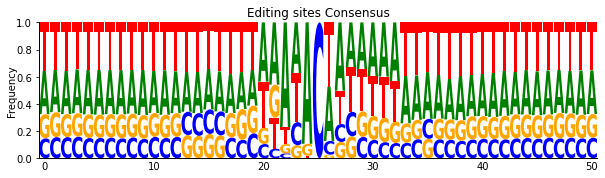

In [132]:
# produce consensus
create_sequence_logo(ed_sites_seqs, title="Editing sites Consensus")
print(ed_sites_seqs.T)

In [135]:
# take a sample of no editing sites
no_ed_sites_sample_set = random.sample(no_ed_sites_set, int(len(no_ed_sites_set)*0.1))
print(len(no_ed_sites_sample_set))
print(no_ed_sites_sample_set)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/tmp/ipykernel_204889/1793642235.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  no_ed_sites_sample_set = random.sample(no_ed_sites_set, int(len(no_ed_sites_set)*0.1))


In [137]:
# perform the same operation on no editing sites examples

# open hg38 reference
ref = pysam.FastaFile(ref_filepath)

no_ed_sites_seqs = []
with tqdm(total=len(no_ed_sites_sample_set)) as pbar:
    for s in no_ed_sites_sample_set:
        site = s.split(":")
        region = site[0]
        pos1based=int(site[1])
        pos0based=pos1based-1
        start = pos0based-interval
        stop = pos0based+interval+1
        strand= "+" if int(site[2]) == 1 else "-"
        
        if not (strand == "+" or strand == "-"):
            print("ops! Strange strand!")
            break
        try:
            reference = ref.fetch(region, start, stop)
        except ValueError:
            continue
        if strand == "-":
            reference = get_rev_compl(reference)
        
        # append to ed_sites_seqs list as list
        if len(reference) == interval*2+1:
            if reference[interval] == "C":
                no_ed_sites_seqs.append(list(reference))
        else:
            print("OPS length wrong")
        pbar.update(1)
        
no_ed_sites_seqs = pd.DataFrame(no_ed_sites_seqs, columns=[f"{i}" for i in range(interval*2+1)])
print(no_ed_sites_seqs.shape)
print(no_ed_sites_seqs)
no_ed_sites_seqs_freqs = {}
for rel_pos in no_ed_sites_seqs:
        no_ed_sites_seqs_freqs[int(rel_pos)] = no_ed_sites_seqs[rel_pos].value_counts().sort_index()
no_ed_sites_seqs = pd.DataFrame(no_ed_sites_seqs_freqs).fillna(0)

depths = no_ed_sites_seqs.sum().tolist()
no_ed_sites_seqs = no_ed_sites_seqs / depths
no_ed_sites_seqs = no_ed_sites_seqs.T

ref.close()

100%|█████████▉| 285885/285886 [00:14<00:00, 19760.84it/s]

OPS length wrong


(285884, 51)
        0  1  2  3  4  5  6  7  8  9  ... 41 42 43 44 45 46 47 48 49 50
0       G  G  C  T  G  A  G  T  T  C  ...  G  C  C  A  G  A  A  G  C  A
1       A  A  A  A  C  T  A  G  A  A  ...  T  C  A  A  A  G  T  T  G  T
2       T  C  A  A  G  A  T  T  T  G  ...  C  A  A  T  G  A  A  A  G  A
3       T  T  T  A  A  T  G  G  A  C  ...  T  A  T  A  A  A  T  G  C  T
4       G  C  A  C  T  G  G  C  C  C  ...  G  C  C  C  C  T  T  C  T  A
...    .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
285879  A  A  T  G  A  A  T  T  T  T  ...  A  C  A  C  A  A  T  G  C  T
285880  T  T  A  C  T  T  T  A  T  T  ...  A  T  G  G  T  A  A  A  G  A
285881  G  C  C  T  A  C  A  C  C  T  ...  T  G  A  G  A  A  C  A  G  G
285882  C  A  A  A  G  G  T  T  C  T  ...  A  G  G  T  A  A  A  T  C  A
285883  A  A  A  A  G  A  A  G  A  T  ...  C  A  T  C  T  A  A  A  G  C

[285884 rows x 51 columns]


         0         1         2         3         4         5         6   \
A  0.252602  0.247975  0.257440  0.252242  0.246170  0.253879  0.252672   
C  0.239713  0.249461  0.235333  0.237904  0.250073  0.239440  0.240814   
G  0.238271  0.240898  0.238495  0.241357  0.244064  0.239258  0.241000   
T  0.269413  0.261666  0.268731  0.268497  0.259693  0.267423  0.265513   

         7         8         9   ...        41        42        43        44  \
A  0.245187  0.255523  0.254729  ...  0.265800  0.262512  0.254205  0.264467   
C  0.251557  0.240535  0.240776  ...  0.233990  0.233780  0.245292  0.232105   
G  0.242731  0.240682  0.244176  ...  0.247719  0.250210  0.251595  0.247013   
T  0.260525  0.263261  0.260319  ...  0.252491  0.253498  0.248909  0.256415   

         45        46        47        48        49        50  
A  0.260008  0.255041  0.265657  0.263352  0.255404  0.266164  
C  0.232976  0.243022  0.232280  0.230275  0.242829  0.232475  
G  0.250812  0.251773  0.246401

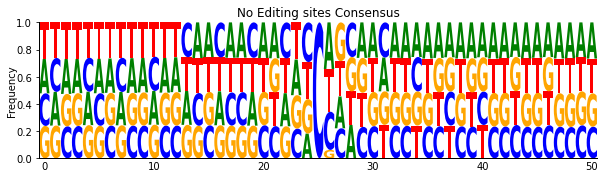

In [138]:
# produce consensus
create_sequence_logo(no_ed_sites_seqs, title="No Editing sites Consensus")
print(no_ed_sites_seqs.T)

In [139]:
# save to disk patterns of editing and no editing sites (subsample)
ed_sites_seqs.T.to_csv("Editing_Sites_Consensus.txt", sep="\t")
no_ed_sites_seqs.T.to_csv("No_Editing_Sites_Consensus.txt", sep="\t")